In [16]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test', 'train', 'train.csv', 'sample_submission.csv']


In [17]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import scipy
import cv2

import keras

In [18]:

import random

**Exploration**


In [19]:

train_data = pd.read_csv('../input/train.csv')

In [20]:

train_data.shape

(17500, 2)

In [21]:

train_data.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [22]:

train_data.has_cactus.unique()

array([1, 0])

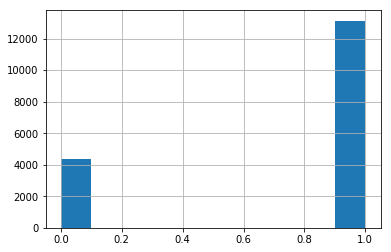

In [23]:

train_data.has_cactus.hist()

In [24]:

train_data.has_cactus.value_counts()

1    13136
0     4364
Name: has_cactus, dtype: int64

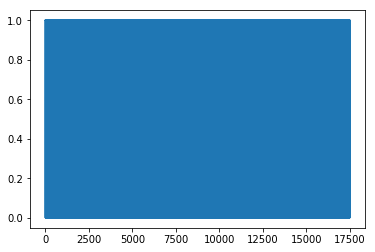

In [25]:

train_data.has_cactus.plot()

**Model**

In [26]:

def image_generator2(batch_size = 16, all_data=True, shuffle=True, train=True, indexes=None):
    while True:
        if indexes is None:
            if train:
                if all_data:
                    indexes = np.arange(train_data.shape[0])
                else:
                    indexes = np.arange(train_data[:15000].shape[0])
                if shuffle:
                    np.random.shuffle(indexes)
            else:
                indexes = np.arange(train_data[15000:].shape[0])
            
        N = int(len(indexes) / batch_size)
       

        # Read in each input, perform preprocessing and get labels
        for i in range(N):
            current_indexes = indexes[i*batch_size: (i+1)*batch_size]
            batch_input = []
            batch_output = [] 
            for index in current_indexes:
                img = mpimg.imread('../input/train/train/' + train_data.id[index])
                batch_input += [img]
                batch_input += [img[::-1, :, :]]
                batch_input += [img[:, ::-1, :]]
                batch_input += [np.rot90(img)]
                
                temp_img = np.zeros_like(img)
                temp_img[:28, :, :] = img[4:, :, :]
                batch_input += [temp_img]
                
                temp_img = np.zeros_like(img)
                temp_img[:, :28, :] = img[:, 4:, :]
                batch_input += [temp_img]
                
                temp_img = np.zeros_like(img)
                temp_img[4:, :, :] = img[:28, :, :]
                batch_input += [temp_img]
                
                temp_img = np.zeros_like(img)
                temp_img[:, 4:, :] = img[:, :28, :]
                batch_input += [temp_img]
                
                batch_input += [cv2.resize(img[2:30, 2:30, :], (32, 32))]
                
                batch_input += [scipy.ndimage.interpolation.rotate(img, 10, reshape=False)]
                
                batch_input += [scipy.ndimage.interpolation.rotate(img, 5, reshape=False)]
                
                
                for _ in range(11):
                    batch_output += [train_data.has_cactus[index]]
                
            batch_input = np.array( batch_input )
            batch_output = np.array( batch_output )
        
            yield( batch_input, batch_output.reshape(-1, 1) )

In [27]:
positive_examples = train_data[train_data.has_cactus==1]
negative_examples = train_data[train_data.has_cactus==0]

In [28]:
def augment_img(img):
    batch_input = []
    batch_input += [img]
    batch_input += [img[::-1, :, :]]
    batch_input += [img[:, ::-1, :]]
    batch_input += [np.rot90(img)]
                
    temp_img = np.zeros_like(img)
    temp_img[:28, :, :] = img[4:, :, :]
    batch_input += [temp_img]
                
    temp_img = np.zeros_like(img)
    temp_img[:, :28, :] = img[:, 4:, :]
    batch_input += [temp_img]
                
    temp_img = np.zeros_like(img)
    temp_img[4:, :, :] = img[:28, :, :]
    batch_input += [temp_img]
                
    temp_img = np.zeros_like(img)
    temp_img[:, 4:, :] = img[:, :28, :]
    batch_input += [temp_img]
                
    batch_input += [cv2.resize(img[2:30, 2:30, :], (32, 32))]
                
    batch_input += [scipy.ndimage.interpolation.rotate(img, 10, reshape=False)]
                
    batch_input += [scipy.ndimage.interpolation.rotate(img, 5, reshape=False)]
    
    return batch_input

In [29]:

def image_generator(batch_size = 8, all_data=True, shuffle=True, train=True, indexes=None):
    while True:
        if indexes is None:
            if train:
                indexes = positive_examples.index.tolist()
                neg_indexes = negative_examples.index.tolist()
                if shuffle:
                    np.random.shuffle(indexes)
                    np.random.shuffle(neg_indexes)
            
        N = int(len(indexes) / (batch_size/2))
        neg_N = int(len(neg_indexes) / (batch_size/2))
       
        j = 0

        # Read in each input, perform preprocessing and get labels
        for i in range(N):
            current_indexes = indexes[i*(batch_size//2): (i+1)*(batch_size//2)]
            current_neg_indexes = neg_indexes[j*(batch_size//2): (j+1)*(batch_size//2)]
            j = (j + 1) % neg_N
            batch_input = []
            batch_output = [] 
            for ind in range(len(current_indexes)):
                index = current_indexes[ind]
                neg_index = current_neg_indexes[ind]
                
                img = mpimg.imread('../input/train/train/' + train_data.id[index])
                batch_input.extend(augment_img(img))
                for _ in range(11):
                    batch_output += [train_data.has_cactus[index]]
                
                neg_img = mpimg.imread('../input/train/train/' + train_data.id[neg_index])
                batch_input.extend(augment_img(neg_img))
                for _ in range(11):
                    batch_output += [train_data.has_cactus[neg_index]]
                
#                 factor = 0.05
#                 new_img = factor*neg_img + (1-factor)*img
#                 batch_input.append(new_img)
#                 batch_output += [factor*train_data.has_cactus[neg_index]+(1-factor)*train_data.has_cactus[index]]
                
#                 factor = 0.95
#                 new_img = factor*neg_img + (1-factor)*img
#                 batch_input.append(new_img)
#                 batch_output += [factor*train_data.has_cactus[neg_index]+(1-factor)*train_data.has_cactus[index]]
            
                
                
            batch_input = np.array( batch_input )
            batch_output = np.array( batch_output )
        
            yield( batch_input, batch_output.reshape(-1, 1) )

In [30]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, (5, 5), input_shape=(32, 32, 3)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.LeakyReLU(alpha=0.3))

model.add(keras.layers.Conv2D(64, (5, 5)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.LeakyReLU(alpha=0.3))

model.add(keras.layers.Conv2D(128, (5, 5)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.LeakyReLU(alpha=0.3))

model.add(keras.layers.Conv2D(128, (5, 5)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.LeakyReLU(alpha=0.3))

model.add(keras.layers.Conv2D(256, (3, 3)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.LeakyReLU(alpha=0.3))

model.add(keras.layers.Conv2D(256, (3, 3)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.LeakyReLU(alpha=0.3))

model.add(keras.layers.Conv2D(512, (3, 3)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.LeakyReLU(alpha=0.3))

model.add(keras.layers.Flatten())


model.add(keras.layers.Dense(100))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.LeakyReLU(alpha=0.3))

model.add(keras.layers.Dense(1, activation='sigmoid'))

In [31]:

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 28, 28, 64)        4864      
_________________________________________________________________
batch_normalization_9 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 24, 64)        102464    
_________________________________________________________________
batch_normalization_10 (Batc (None, 24, 24, 64)        256       
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 20, 20, 128)       204928    
__________

In [32]:

opt = keras.optimizers.SGD(lr=0.0001, momentum=0.9, nesterov=True)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [33]:
def step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=10):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch/step_size))
    
    return keras.callbacks.LearningRateScheduler(schedule)

lr_sched = step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=2)
early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=3)

model.fit_generator(image_generator(), steps_per_epoch= train_data.shape[0] / 8, epochs=10, callbacks=[lr_sched, early_stop])

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
2188/2187 [==============================] - 83s 38ms/step - loss: 0.0967 - acc: 0.9636
Epoch 2/10
2188/2187 [==============================] - 77s 35ms/step - loss: 0.0377 - acc: 0.9866
Epoch 3/10
2188/2187 [==============================] - 77s 35ms/step - loss: 0.0205 - acc: 0.9933
Epoch 4/10
2188/2187 [==============================] - 76s 35ms/step - loss: 0.0129 - acc: 0.9959
Epoch 5/10
2188/2187 [==============================] - 76s 35ms/step - loss: 0.0069 - acc: 0.9980
Epoch 6/10
2188/2187 [==============================] - 77s 35ms/step - loss: 0.0051 - acc: 0.9987
Epoch 7/10
2188/2187 [==============================] - 77s 35ms/step - loss: 0.0030 - acc: 0.9995
Epoch 8/10
2188/2187 [==============================] - 76s 35ms/step - loss: 0.0020 - acc: 0.9997
Epoch 9/10
2188/2187 [==============================] - 76s 35ms/step - loss: 0.0015 - acc: 0.9999
Epoch 10/10
2188/2187 [==============================] - 76s 

In [34]:
# def step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=10):
#     '''
#     Wrapper function to create a LearningRateScheduler with step decay schedule.
#     '''
#     def schedule(epoch):
#         return initial_lr * (decay_factor ** np.floor(epoch/step_size))
    
#     return keras.callbacks.LearningRateScheduler(schedule)

# lr_sched = step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=2)

# model.fit_generator(image_generator(), steps_per_epoch= train_data.shape[0] / 8, epochs=20, callbacks=[lr_sched])

In [35]:
model.evaluate_generator(image_generator2(), steps=train_data.shape[0]//16)

[0.009612761079340646, 0.9964027291356372]

In [36]:
# model.evaluate_generator(image_generator(), steps=train_data.shape[0]//8)

In [37]:

# keras.backend.eval(model.optimizer.lr.assign(0.00001))

In [38]:

# model.fit_generator(image_generator(), steps_per_epoch= train_data.shape[0] / 16, epochs=15)

In [39]:

indexes = np.arange(train_data.shape[0])
N = int(len(indexes) / 64)   
batch_size = 64

wrong_ind = []
for i in range(N):
            current_indexes = indexes[i*64: (i+1)*64]
            batch_input = []
            batch_output = [] 
            for index in current_indexes:
                img = mpimg.imread('../input/train/train/' + train_data.id[index])
                batch_input += [img]
                batch_output.append(train_data.has_cactus[index])
            
            batch_input = np.array( batch_input )
#             batch_output = np.array( batch_output )

            model_pred = model.predict_classes(batch_input)
            for j in range(len(batch_output)):
                if model_pred[j] != batch_output[j]:
                    wrong_ind.append(i*batch_size+j)

In [40]:

len(wrong_ind)

20

In [41]:

indexes = np.arange(train_data.shape[0])
N = int(len(indexes) / 64)   
batch_size = 64

wrong_ind = []
for i in range(N):
            current_indexes = indexes[i*64: (i+1)*64]
            batch_input = []
            batch_output = [] 
            for index in current_indexes:
                img = mpimg.imread('../input/train/train/' + train_data.id[index])
                batch_input += [img[::-1, :, :]]
                batch_output.append(train_data.has_cactus[index])
            
            batch_input = np.array( batch_input )

            model_pred = model.predict_classes(batch_input)
            for j in range(len(batch_output)):
                if model_pred[j] != batch_output[j]:
                    wrong_ind.append(i*batch_size+j)

In [42]:

len(wrong_ind)

74

In [43]:

indexes = np.arange(train_data.shape[0])
N = int(len(indexes) / 64)   
batch_size = 64

wrong_ind = []
for i in range(N):
            current_indexes = indexes[i*64: (i+1)*64]
            batch_input = []
            batch_output = [] 
            for index in current_indexes:
                img = mpimg.imread('../input/train/train/' + train_data.id[index])
                batch_input += [img[:, ::-1, :]]
                batch_output.append(train_data.has_cactus[index])
            
            batch_input = np.array( batch_input )

            model_pred = model.predict_classes(batch_input)
            for j in range(len(batch_output)):
                if model_pred[j] != batch_output[j]:
                    wrong_ind.append(i*batch_size+j)

In [44]:

len(wrong_ind)

69

In [45]:

!ls ../input/test/test/* | wc -l

4000


In [46]:

test_files = os.listdir('../input/test/test/')

In [47]:

len(test_files)

4000

In [48]:

batch = 40
all_out = []
for i in range(int(4000/batch)):
    images = []
    for j in range(batch):
        img = mpimg.imread('../input/test/test/'+test_files[i*batch + j])
        images += [img]
    out = model.predict(np.array(images))
    all_out += [out]

In [49]:

all_out = np.array(all_out).reshape((-1, 1))


In [50]:

all_out.shape

(4000, 1)

In [51]:

sub_file = pd.DataFrame(data = {'id': test_files, 'has_cactus': all_out.reshape(-1).tolist()})

In [52]:

sub_file.to_csv('sample_submission.csv', index=False)